# How Did Bolivia's 2019 TREP Count Tally Sheets? #

## Introduction ##

First, a basic explanation of Bolivia's 2019 TREP vote count, translated from a <a href="https://www.scribd.com/document/432731081/Informe-de-Neotec-sobre-las-elecciones-en-Bolivia">report</a> by the contractor who developed and administered it:

<blockquote><h2>TREP</h2>
The Transmission of Preliminary Electoral Results (<i>Transmisión de Resultados Electorales Preliminares</i> or TREP, in Spanish) has the objective of preserving the images of the tally sheets at the polling place and offering reliable preliminary election results within a few hours.

<h3>Recording of Tally Sheets at the Polling Place</h3>
More than 7,600 results transmission operators took images of and recorded the votes for 34,178 tally sheets (98.9% of all tally sheets) using an application on their mobile phones. The images and voting data were automatically sent to servers in the cloud. The mobile application stores the recorded voting data and photos of the tally sheets on the phone. Pick-up routes were implemented for operators deployed in areas without cell phone service, using more than 600 vehicles. The mobile application sends the data and image as soon as the phone enters an area with cell phone service. Fifty-one satellite antennas were also installed in strategic locations allowing several operators in nearby towns to reach the satellite transmission post and send their recorded tally sheets. At least one operator was deployed in each polling place, both in Bolivia and abroad, and in those polling places with more than 10 polling stations, one operator was deployed for every 10 stations. The operator recorded the voting data and took the photograph of the tally sheet in front of the polling station's electoral jury, party delegates, and all those present. This operation provides transparency and preserves the content of the tally sheet at the polling place.

<h3>Verification of Tally Sheets</h3>

350 tally sheet verification operators hired by the Civic Registry Service (*Servicio de Registro Cívico* or SERECI, in Spanish) recorded the votes written on the tally sheet based on the image sent from the mobile phone. The verifier can't see the votes recorded on the phone, only the image. In this way, it constitutes a second, independent record of the content of the tally sheet. When the votes recorded on the phone are identical to the votes recorded by the verifier, the tally sheet is considered verified and is published. When the votes recorded on the phone differ from the votes recorded by the verifier, the tally sheet enters a review process. When the image is illegible, incomplete, not a tally sheet, is from the wrong station, or has corrections that can't be interpreted simply, the verifiers send the tally sheet to the review process. The verifiers receive tally sheets at random.

<h3>Review and Approval of Tally Sheets</h3>

A team of 20 approvers (SERECI functionaries) reviews the tally sheets that during the verification process had differences with the initial record from the mobile phone. The approver can see the image of the tally sheet, the verifier's record of the votes, and the voting data from the mobile phone. If the approver determines that the tally sheet image is incorrect or insufficiently legible, they leave the tally sheet as marked for review. The same applies if the tally sheet contains corrections that aren't simple and evident. If the tally sheet image is adequate and any corrections on it are simple and evident, the approver records the correct voting data and approves the tally sheet.</blockquote>

I want to focus on this part: "The verifiers receive tally sheets at random." This wasn't true.

## Preparations ##

To show that, first I'll import some libraries.

In [1]:
# Standard libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# RNG for later.
rng = np.random.default_rng(seed=0)

# Set graph defaults.
sns.set_theme(palette='bright')
plt.rcParams['axes.labelpad'] = 10

# Common formatters.
pct_format = mpl.ticker.PercentFormatter(1)
hhmm_format = mpl.dates.DateFormatter('%H:%M')

# Function to set graph axis formatter (in chaining-style).
def _formatter(axis, formatter):
    axis.set_major_formatter(formatter)
    return axis.axes
mpl.axis.XAxis.formatter = _formatter
mpl.axis.YAxis.formatter = _formatter

Next, I'll load a dataset with records of all valid tally sheet transcriptions in the TREP:

In [3]:
# Transcription log from the TREP. (99% of tally sheets have 1+ transcription, but 1% have none.)
trep = pd.read_parquet('data/OEA_TREP_LogCompleto_19G_2019.11.03.06.53.parquet')

# Map to translate ElecActa (TallySheetElection).
ElecActaMap = {
    'Presidente y Vicepresidente': 'President',
    'Diputados Uninominales': 'Deputy',
    'Diputados Especiales': 'Special Deputy'
}

# Category to give ElecActa an order.
ElecActaCategory = pd.CategoricalDtype(
    ordered=True,
    categories=[
        'President',
        'Deputy',
        'Special Deputy'
    ]
)

# Apply ElecActaMap and ElecActaCategory.
trep.ElecActa = trep.ElecActa.map(ElecActaMap).astype(ElecActaCategory)

I'll also load data from the *Cómputo Oficial* (Official Count).

In [4]:
"""
    The TREP data has no records for ~1% of tally sheets, so to obtain records
    for all the tally sheets, I need to load the Official Count data too.
"""
# Data from the Cómputo Oficial (Official Count), which contains one record for each tally sheet.
computo = pd.read_parquet('data/2.RecepcionSobres_final.parquet')

# Apply ElecActaMap and ElecActaCategory.
computo.ElecActa = computo.ElecActa.map(ElecActaMap).astype(ElecActaCategory)

# Set NumMesa (StationNumber) and ElecActa (TallySheetElection) as index.
computo.set_index(['NumMesa', 'ElecActa'], inplace=True)

For each valid TREP transcription, I'll assign a UserType (ie. who sent it):

In [5]:
# Which type of user provided the transcription.
trep['UserType'] = pd.Categorical(
    np.where(
        trep.EstadoActa == 'Registrada',
        'MobileUser',
        np.where(
            trep.AprobadorDate.isna(),
            'SereciVerifier',
            'SereciApprover'
        )
    ),
    ordered=True,
    categories=[
        'MobileUser',
        'SereciVerifier',
        'SereciApprover'
    ]
)

Then, for each tally sheet, I'll get the time of each UserType's earliest TREP transcription:

In [6]:
"""
    TREP users didn't transcribe whole tally sheets but rather individual tally sheet
    *columns*, defined as an election on a tally sheet. They're called tally sheet columns
    because, on the tally sheet document, each election has its own column. It's a nuisance
    to have to say tally sheet *columns* over and over, though, so I say "tally sheet."
    
    A sample image of a tally sheet document with President/Deputy columns:
    https://archive.org/download/bolivia_eg2019_result/COMPUTO/2019-bolivia-computo-actas.zip/21421.jpg
"""
# For each tally sheet, get the time of each UserType's earliest transcription.
trep_times = (
    trep.pivot_table(
        index=['NumMesa', 'ElecActa'],
        columns='UserType',
        values='Fecha Registro en Log', # "Date (of) Record in Log", a simple generic timestamp.
        aggfunc='min'
    )
    .reindex(computo.index) # I want records for 100% of tally sheets.
)
trep_times

UserType                   MobileUser      SereciVerifier SereciApprover
NumMesa ElecActa                                                        
1001    President 2019-10-20 13:10:42 2019-10-20 13:11:56            NaT
1002    President 2019-10-20 11:41:48 2019-10-20 11:45:29            NaT
1003    President 2019-10-20 17:27:26 2019-10-20 17:29:26            NaT
1004    President 2019-10-20 17:34:42 2019-10-20 17:39:41            NaT
1005    President 2019-10-20 17:05:27 2019-10-20 17:20:15            NaT
...                               ...                 ...            ...
90387   Deputy    2019-10-20 17:49:34 2019-10-20 17:50:10            NaT
90388   President 2019-10-20 18:57:43 2019-10-20 18:59:31            NaT
        Deputy    2019-10-20 18:57:45 2019-10-20 19:00:52            NaT
90389   President 2019-10-20 17:17:58 2019-10-20 17:25:52            NaT
        Deputy    2019-10-20 17:17:59 2019-10-20 17:27:33            NaT

[68140 rows x 3 columns]

## How SERECI Verifiers Received Tally Sheets ##

SERECI Verifiers received tally sheets from a non-random priority queue which I'll describe below.

### Operations ###

A tally sheet was inserted into this queue when the system had both:

1. A tally sheet transcription from the Mobile User. (Timestamp <font color="green">available</font> as *MobileUser*.)
2. A tally sheet photo from the Mobile User. (Timestamp <font color="red">unavailable</font>.)

When a SERECI Verifier asked for a sheet to transcribe, the highest-priority sheet was dequeued and served to them. (Timestamp <font color="red">unavailable</font>.) Then, the SERECI Verifier transcribed it. (Timestamp <font color="green">available</font> as *SereciVerifier*.) Or rejected it, causing it to be set aside for five minutes or more. (Timestamp <font color="red">unavailable</font>.)

### Priority ###

The queue prioritized tally sheets in <code>PriorityDecile DESC, NumMesa ASC</code> order.

To obtain PriorityDecile, first sort all tally sheets by NumMesa (StationNumber) and ElecActa (TallySheetElection).

In [7]:
# Note: The original Official Count file was already sorted like this. I'm just being explicit about it.
computo.sort_index(inplace=True) # Index: [NumMesa, ElecActa].

Next, in order, assign tally sheets to PriorityDeciles with this Mod-10 counter:

In [8]:
computo['PriorityDecile'] = (1 - np.arange(len(computo))) % 10

At the start of the data, this produces:

In [9]:
computo[['PriorityDecile']].head(20)

,,PriorityDecile
NumMesa,ElecActa,
1001,President,1
1002,President,0
1003,President,9
1004,President,8
1005,President,7
1006,President,6
1007,President,5
1008,President,4
1009,President,3


However, those are all overseas stations, which only vote for president. Within Bolivia, there are elections for deputy too:

In [10]:
NumMesaRandom = computo[computo.Pais == 'Bolivia'].reset_index().NumMesa.sample(n=1, random_state=rng).squeeze()
computo.loc[computo.index.get_level_values('NumMesa') >= NumMesaRandom, ['PriorityDecile']].head(20)

PriorityDecile
NumMesa ElecActa                 
75448   President               6
        Deputy                  5
75449   President               4
        Deputy                  3
75450   President               2
        Deputy                  1
75451   President               0
        Deputy                  9
75452   President               8
        Deputy                  7
75453   President               6
        Deputy                  5
75454   President               4
        Deputy                  3
75455   President               2
        Deputy                  1
75456   President               0
        Deputy                  9
75457   President               8
        Deputy                  7

The other component of priority is NumMesa (StationNumber), a unique numeric identifier for polling stations. To create it, the Plurinational Electoral Organ (*Órgano Electoral Plurinacional* or OEP, in Spanish) split the election's geography into ten regions—*Exterior* (Overseas) plus the nine departments in Bolivia—and assigned each region a starting NumMesa value. For *Exterior*, it's 1001, but for Bolivia's nine departments, it's <code>(department_id * 10000) + 1</code>. For example, Chuquisaca's departmental identifier is 1, so its NumMesa values start at <code>(1 * 10000) + 1</code> or 10001. La Paz's is 2, so it starts at <code>(2 * 10000) + 1</code> or 20001. Etc, etc. Then, within each region, stations were sorted based on a series of other geographic identifiers below the regional level (the identifiers are available <a href="https://geoelectoral.oep.org.bo/oep/rest/services/EleccionesGrales2019">here</a> and <a href="https://archive.org/download/bolivia_eg2019_result/PADRON/raw/">here</a>). Once a region's polling stations were sorted, they were assigned NumMesa values in sequential order beginning with the region's first NumMesa value. So, the first station in Chuquisaca was given 10001, the second was given 10002, and so on, up to Chuquisaca's 1828th and final polling station, which was given 11828. Likewise, the first station in La Paz was given 20001, the second was given 20002, and so on, up to La Paz's 8988th and final polling station, which was given 28988. Etc, etc.

As a result, NumMesa breaks down like this by region:

In [11]:
computo['Region'] = (
    computo
        .Dep.where(computo.Pais == 'Bolivia', 'Exterior')
        .pipe(lambda x: pd.Categorical(
            x.rename('Region'),
            ordered=True,
            categories=x.drop_duplicates()
        ))
)

In [12]:
(
    computo
        .reset_index('NumMesa')
        .groupby('Region')
        .NumMesa.agg(
            NumMesaMin='min',
            NumMesaMax='max',
            NStations='nunique'
        )
)

,NumMesaMin,NumMesaMax,NStations
Region,,,
Exterior,1001,2507,1507
Chuquisaca,10001,11828,1828
La Paz,20001,28988,8988
Cochabamba,30001,36134,6134
Oruro,40001,41646,1646
Potosí,50001,52338,2338
Tarija,60001,61802,1802
Santa Cruz,70001,78621,8621
Beni,80001,81302,1302


To make analysis easier, I'll reduce <code>PriorityDecile DESC, NumMesa ASC</code> to a value named <code>Priority</code> on the interval [0, 1]:

In [13]:
"""
    I think the queue's "PriorityDecile DESC, NumMesa ASC" priority structure was
    partly intentional, partly unintentional. PriorityDecile—a crude attempt to
    'randomize' the tally sheets—was definitely intentional, but the use of NumMesa
    doesn't make much sense to me, so I believe it was an accident. My best guess
    is that it occurred because the priority queue worked with data already in
    "NumMesa ASC, ElecActa" order and stable-sorted it by PriorityDecile DESC,
    unintentionally producing a "PriorityDecile DESC, NumMesa ASC, ElecActa" sort,
    which is equivalent to the "PriorityDecile DESC, NumMesa ASC" sort here.
    
    More specifically, I could take this line of code below:
        .sort_values(['PriorityDecile', 'NumMesa'], ascending=[False, True])
        
    And replace it with this:
        .sort_values('PriorityDecile', ascending=False, kind='stable')
        
    And it would produce the same result.
"""
trep_times = trep_times.join(
    computo
        .sort_values(['PriorityDecile', 'NumMesa'], ascending=[False, True])
        .pipe(lambda x: pd.DataFrame({
            'Priority': np.linspace(1, 0, len(x)),
            'PriorityDecile': x.PriorityDecile
        }))
)
trep_times

MobileUser      SereciVerifier SereciApprover  \
NumMesa ElecActa                                                           
1001    President 2019-10-20 13:10:42 2019-10-20 13:11:56            NaT   
1002    President 2019-10-20 11:41:48 2019-10-20 11:45:29            NaT   
1003    President 2019-10-20 17:27:26 2019-10-20 17:29:26            NaT   
1004    President 2019-10-20 17:34:42 2019-10-20 17:39:41            NaT   
1005    President 2019-10-20 17:05:27 2019-10-20 17:20:15            NaT   
...                               ...                 ...            ...   
90387   Deputy    2019-10-20 17:49:34 2019-10-20 17:50:10            NaT   
90388   President 2019-10-20 18:57:43 2019-10-20 18:59:31            NaT   
        Deputy    2019-10-20 18:57:45 2019-10-20 19:00:52            NaT   
90389   President 2019-10-20 17:17:58 2019-10-20 17:25:52            NaT   
        Deputy    2019-10-20 17:17:59 2019-10-20 17:27:33            NaT   

                   Priority  PriorityDecile  
NumMesa ElecActa                             
1001    President  0.199988               1  
1002    President  0.099987               0  
1003    President  1.000000               9  
1004    President  0.899999               8  
1005    President  0.799997               7  
...                     ...             ...  
90387   Deputy     0.600009               6  
90388   President  0.500007               5  
        Deputy     0.400006               4  
90389   President  0.300004               3  
        Deputy     0.200003               2  

[68140 rows x 5 columns]

## Evidence from the Election ##

Tally sheets were always served in descending order by Priority, but this was only apparent when there was a substantial backlog for the system to manage. Without such a backlog, tally sheets were served to SERECI Verifiers almost as soon as the system received them, which masked the prioritization the system applied.

To show this, I'll review all the times in the vote count when there was a substantial backlog of tally sheets.

### Backlog Event #1 ###

From 16:00 to 16:45 on Election Day, SERECI Verifiers took a break. While SERECI Verifiers were on break, Mobile Users continued to send tally sheets to the system, so a backlog of unprocessed tally sheets built up. When SERECI Verifiers returned, they transcribed this backlog in descending order by Priority.

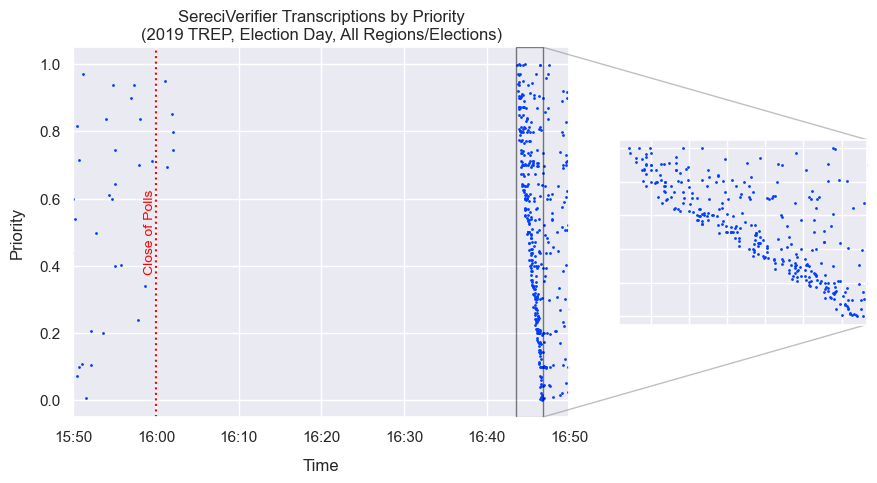

In [14]:
# Main plot.
ax = (
    trep_times.plot.scatter(
        'SereciVerifier',
        'Priority',
        s=1,
        title='SereciVerifier Transcriptions by Priority\n(2019 TREP, Election Day, All Regions/Elections)',
        xlabel='Time',
        xlim=pd.to_datetime(['2019-10-20 15:50', '2019-10-20 16:50'])
    )
    .xaxis.formatter(hhmm_format)
    .axvline(pd.Timestamp('2019-10-20 16:00'), c='red', ls=':')
    .axes.text(
        pd.Timestamp('2019-10-20 16:00'),
        0.5,
        'Close of Polls', # Well, domestic polls.
        c='red',
        size='small',
        ha='right',
        va='center',
        rotation=90
    )
    .axes
)

# Zoom in for detail.
ax_zoom = ax.inset_axes([1.1, 0.25, 0.5, 0.5])
ax_zoom.scatter(
    trep_times.SereciVerifier,
    trep_times.Priority,
    s=1
)
ax_zoom.set_xlim(pd.to_datetime(['2019-10-20 16:43:35', '2019-10-20 16:46:50']))
ax.indicate_inset_zoom(ax_zoom, ec='black')
ax_zoom.tick_params(labelleft=False, labelbottom=False)

### Backlog Event #2 ###

From 17:05 to 17:18, SERECI Verifiers took another break. When they returned, they transcribed the backlog in descending order by Priority again.

<Axes: title={'center': 'SereciVerifier Transcriptions by Priority\n(2019 TREP, Election Day, All Regions/Elections)'}, xlabel='Time', ylabel='Priority'>

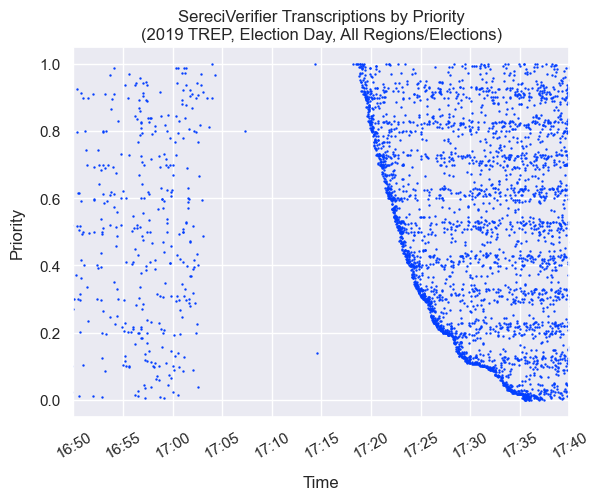

In [15]:
"""
    The bands visible in the graph below are because each decile of Priority
    (ie. a PriorityDecile) is an in-order 10% sample of the electoral geography,
    so geographic patterns in the count produce visual patterns that repeat each decile.
"""
(
    trep_times.plot.scatter(
        'SereciVerifier',
        'Priority',
        s=0.5,
        title='SereciVerifier Transcriptions by Priority\n(2019 TREP, Election Day, All Regions/Elections)',
        xlabel='Time',
        xlim=pd.to_datetime(['2019-10-20 16:50', '2019-10-20 17:40']),
        rot=30
    )
    .xaxis.formatter(hhmm_format)
)

During the break, three sheets were transcribed. Two have pre-break Mobile User transcriptions and routine Priority values, so they would've been served before the break, but the third has a mid-break Mobile User transcription and a 99.97th-percentile Priority value, so it must've been served during the break.

In [16]:
trep_times.loc[
    trep_times.SereciVerifier.between('2019-10-20 17:05', '2019-10-20 17:18'),
    ['MobileUser', 'SereciVerifier', 'Priority']
].sort_values('SereciVerifier')

,,MobileUser,SereciVerifier,Priority
NumMesa,ElecActa,,,
1585,President,2019-10-20 17:02:28,2019-10-20 17:07:16,0.799146
1183,President,2019-10-20 17:06:38,2019-10-20 17:14:23,0.999736
51435,President,2019-10-20 16:52:14,2019-10-20 17:14:33,0.138658


### Backlog Event #3 ###

From 18:10 to 19:32, Mobile Users outpaced SERECI Verifiers, so a backlog built up, then SERECI Verifiers outpaced Mobile Users and drew it down.

In [17]:
"""
    This backlog period is the opposite of the shortage periods analyzed here:
        https://www.reddit.com/user/srslyjuststop/comments/eiu6g1/discussion_about_ethical_hacking_graph_issues_bo1/
"""
backlog_period = pd.to_datetime(['2019-10-20 18:10', '2019-10-20 19:32'])

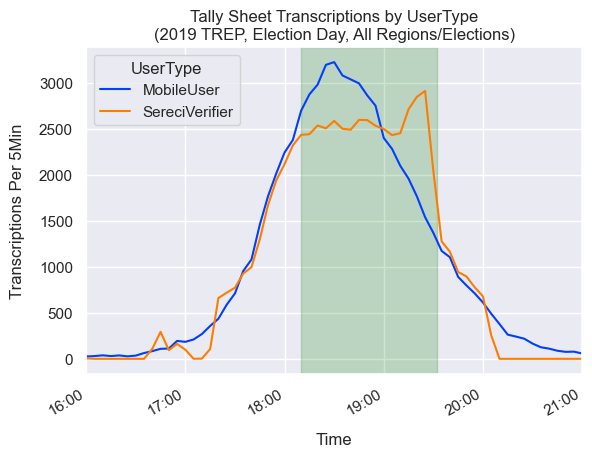

In [18]:
freq = '5Min'
(
    (
        trep_times[['MobileUser', 'SereciVerifier']]
            .stack()
            .rename_axis(index={None: 'UserType'})
            .pipe(lambda x: x.groupby(['UserType', x.dt.floor(freq)]))
            .size()
            .unstack('UserType', fill_value=0)
    )
    .plot(
        title='Tally Sheet Transcriptions by UserType\n(2019 TREP, Election Day, All Regions/Elections)',
        xlabel='Time',
        xlim=pd.to_datetime(['2019-10-20 16:00', '2019-10-20 21:00']),
        ylabel=f'Transcriptions Per {freq}',
        x_compat=True
    )
    .xaxis.formatter(hhmm_format)
    .axvspan(*backlog_period, alpha=0.2, color='green')
)

The backlog was specifically of low-priority sheets, which SERECI Verifiers transcribed in descending order by Priority.

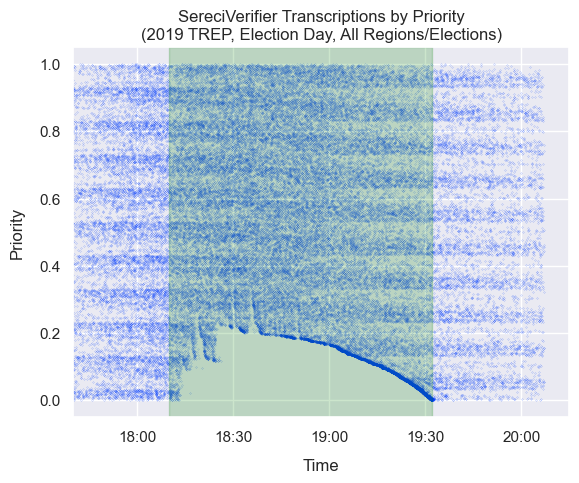

In [19]:
(
    trep_times.plot.scatter(
        'SereciVerifier',
        'Priority',
        s=0.01,
        title='SereciVerifier Transcriptions by Priority\n(2019 TREP, Election Day, All Regions/Elections)',
        xlabel='Time',
        xlim=pd.to_datetime(['2019-10-20 17:40', '2019-10-20 20:15'])
    )
    .xaxis.formatter(hhmm_format)
    .axvspan(*backlog_period, alpha=0.2, color='green')
)

At 19:32, the queue was exhausted. SERECI Verifiers continued to click the dequeue button, but now instead of receiving a sheet to transcribe, they often received a warning that the queue was empty. In response, they started to spam the dequeue button, producing a traffic increase that provoked a security alert.

### Backlog Event #4 ###

At 20:07, in reaction to this alert, officials had the internet at the SERECI offices cut, which halted the work of SERECI Verifiers. However, Mobile Users continued to send sheets to the system. When the count was resumed the next day, SERECI Verifiers transcribed this overnight backlog in descending order by Priority.

<Axes: title={'center': 'SereciVerifier Transcriptions by Priority\n(2019 TREP, Day After Election, All Regions/Elections)'}, xlabel='Sheets Processed', ylabel='Priority'>

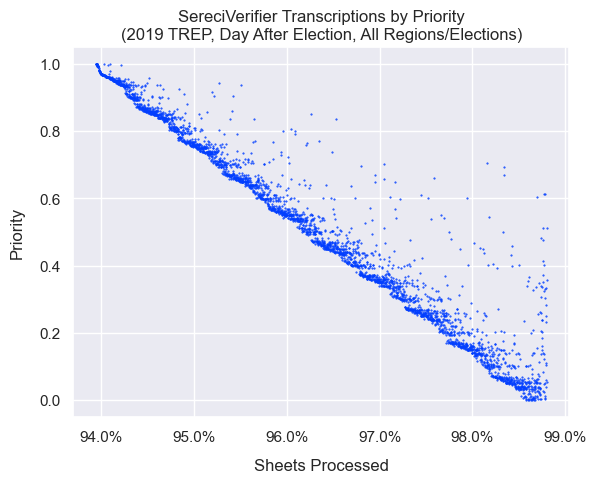

In [20]:
"""
    On October 21st, SERECI Verifiers were active during two periods:
        1. 10:30 to 12:30
        2. 14:40 to 15:00
    I want to show both in a single graph, but I don't want to use time as the x-axis
    because of the long gap between them, so I'll use a time-based percentage.
"""
(
    (
        trep_times
            .assign(SereciVerifierPct=lambda x: x.SereciVerifier.rank() / len(x))
            .query('SereciVerifier.dt.day == 21')
    )
    .plot.scatter(
        'SereciVerifierPct',
        'Priority',
        s=0.25,
        title='SereciVerifier Transcriptions by Priority\n(2019 TREP, Day After Election, All Regions/Elections)',
        xlabel='Sheets Processed'
    )
    .xaxis.formatter(pct_format)
)

## Conclusion ##

The TREP *never* served tally sheets at random. It always served them in <code>PriorityDecile DESC, NumMesa ASC</code> order.